# Desafio 5

Neste desafio, vamos praticar sobre redução de dimensionalidade com PCA e seleção de variáveis com RFE. Utilizaremos o _data set_ [Fifa 2019](https://www.kaggle.com/karangadiya/fifa19), contendo originalmente 89 variáveis de mais de 18 mil jogadores do _game_ FIFA 2019.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [40]:
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as st
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

from loguru import logger

In [2]:
# Algumas configurações para o matplotlib.
# %matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [3]:
fifa = pd.read_csv("fifa.csv")

In [4]:
columns_to_drop = ["Unnamed: 0", "ID", "Name", "Photo", "Nationality", "Flag",
                   "Club", "Club Logo", "Value", "Wage", "Special", "Preferred Foot",
                   "International Reputation", "Weak Foot", "Skill Moves", "Work Rate",
                   "Body Type", "Real Face", "Position", "Jersey Number", "Joined",
                   "Loaned From", "Contract Valid Until", "Height", "Weight", "LS",
                   "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM",
                   "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB",
                   "CB", "RCB", "RB", "Release Clause"
]

try:
    fifa.drop(columns_to_drop, axis=1, inplace=True)
except KeyError:
    logger.warning(f"Columns already dropped")

## Inicia sua análise a partir daqui

In [10]:
fifa.head()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,84.0,95.0,70.0,90.0,86.0,97.0,93.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,84.0,94.0,89.0,81.0,87.0,88.0,81.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,79.0,87.0,62.0,84.0,84.0,96.0,88.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,17.0,13.0,21.0,50.0,13.0,18.0,21.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,93.0,82.0,55.0,92.0,82.0,86.0,85.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [11]:
fifa.shape

(18207, 37)

In [5]:
# Sua análise começa aqui.
fifa.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              18207 non-null  int64  
 1   Overall          18207 non-null  int64  
 2   Potential        18207 non-null  int64  
 3   Crossing         18159 non-null  float64
 4   Finishing        18159 non-null  float64
 5   HeadingAccuracy  18159 non-null  float64
 6   ShortPassing     18159 non-null  float64
 7   Volleys          18159 non-null  float64
 8   Dribbling        18159 non-null  float64
 9   Curve            18159 non-null  float64
 10  FKAccuracy       18159 non-null  float64
 11  LongPassing      18159 non-null  float64
 12  BallControl      18159 non-null  float64
 13  Acceleration     18159 non-null  float64
 14  SprintSpeed      18159 non-null  float64
 15  Agility          18159 non-null  float64
 16  Reactions        18159 non-null  float64
 17  Balance     

In [6]:
fifa.describe()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,25.122206,66.238699,71.307299,49.734181,45.550911,52.298144,58.686712,42.909026,55.371001,47.170824,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,4.669943,6.908930,6.136496,18.364524,19.525820,17.379909,14.699495,17.694408,18.910371,18.395264,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,16.000000,46.000000,48.000000,5.000000,2.000000,4.000000,7.000000,4.000000,4.000000,6.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,21.000000,62.000000,67.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,34.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,25.000000,66.000000,71.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,48.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,28.000000,71.000000,75.000000,64.000000,62.000000,64.000000,68.000000,57.000000,68.000000,62.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,45.000000,94.000000,95.000000,93.000000,95.000000,94.000000,93.000000,90.000000,97.000000,94.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


In [9]:
fifa.isna().sum()

Age                 0
Overall             0
Potential           0
Crossing           48
Finishing          48
HeadingAccuracy    48
ShortPassing       48
Volleys            48
Dribbling          48
Curve              48
FKAccuracy         48
LongPassing        48
BallControl        48
Acceleration       48
SprintSpeed        48
Agility            48
Reactions          48
Balance            48
ShotPower          48
Jumping            48
Stamina            48
Strength           48
LongShots          48
Aggression         48
Interceptions      48
Positioning        48
Vision             48
Penalties          48
Composure          48
Marking            48
StandingTackle     48
SlidingTackle      48
GKDiving           48
GKHandling         48
GKKicking          48
GKPositioning      48
GKReflexes         48
dtype: int64

In [16]:
# criando um dataframe auxliar para analisar a consistencia das variaveis
cons = pd.DataFrame({'colunas' : fifa.columns,
                    'tipo': fifa.dtypes,
                    'missing' : fifa.isna().sum(),
                    'size' : fifa.shape[0],
                    'unicos': fifa.nunique()})
cons['percentual'] = round(cons['missing'] / cons['size'],2)

In [19]:
cons

,colunas,tipo,missing,size,unicos,percentual
Age,Age,int64,0,18207,29,0.0
Overall,Overall,int64,0,18207,48,0.0
Potential,Potential,int64,0,18207,47,0.0
Crossing,Crossing,float64,48,18207,89,0.0
Finishing,Finishing,float64,48,18207,93,0.0
HeadingAccuracy,HeadingAccuracy,float64,48,18207,91,0.0
ShortPassing,ShortPassing,float64,48,18207,85,0.0
Volleys,Volleys,float64,48,18207,87,0.0
Dribbling,Dribbling,float64,48,18207,94,0.0
Curve,Curve,float64,48,18207,89,0.0


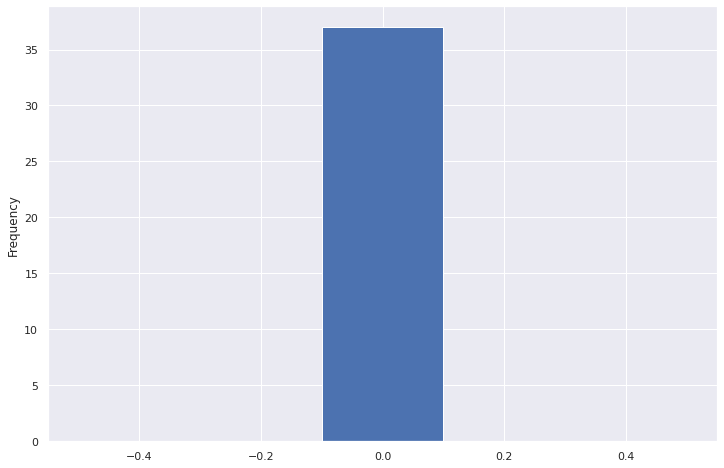

In [20]:
cons.percentual.plot.hist( bins = 5)

In [21]:
print('Contagem de colunas com ATÉ 20% de dados faltantes', cons[cons.percentual < 0.2].shape[0])
print('Contagem de colunas com 0% de dados faltantes',  cons[cons.percentual == 0].shape[0])

Contagem de colunas com ATÉ 20% de dados faltantes 37
Contagem de colunas com 0% de dados faltantes 37


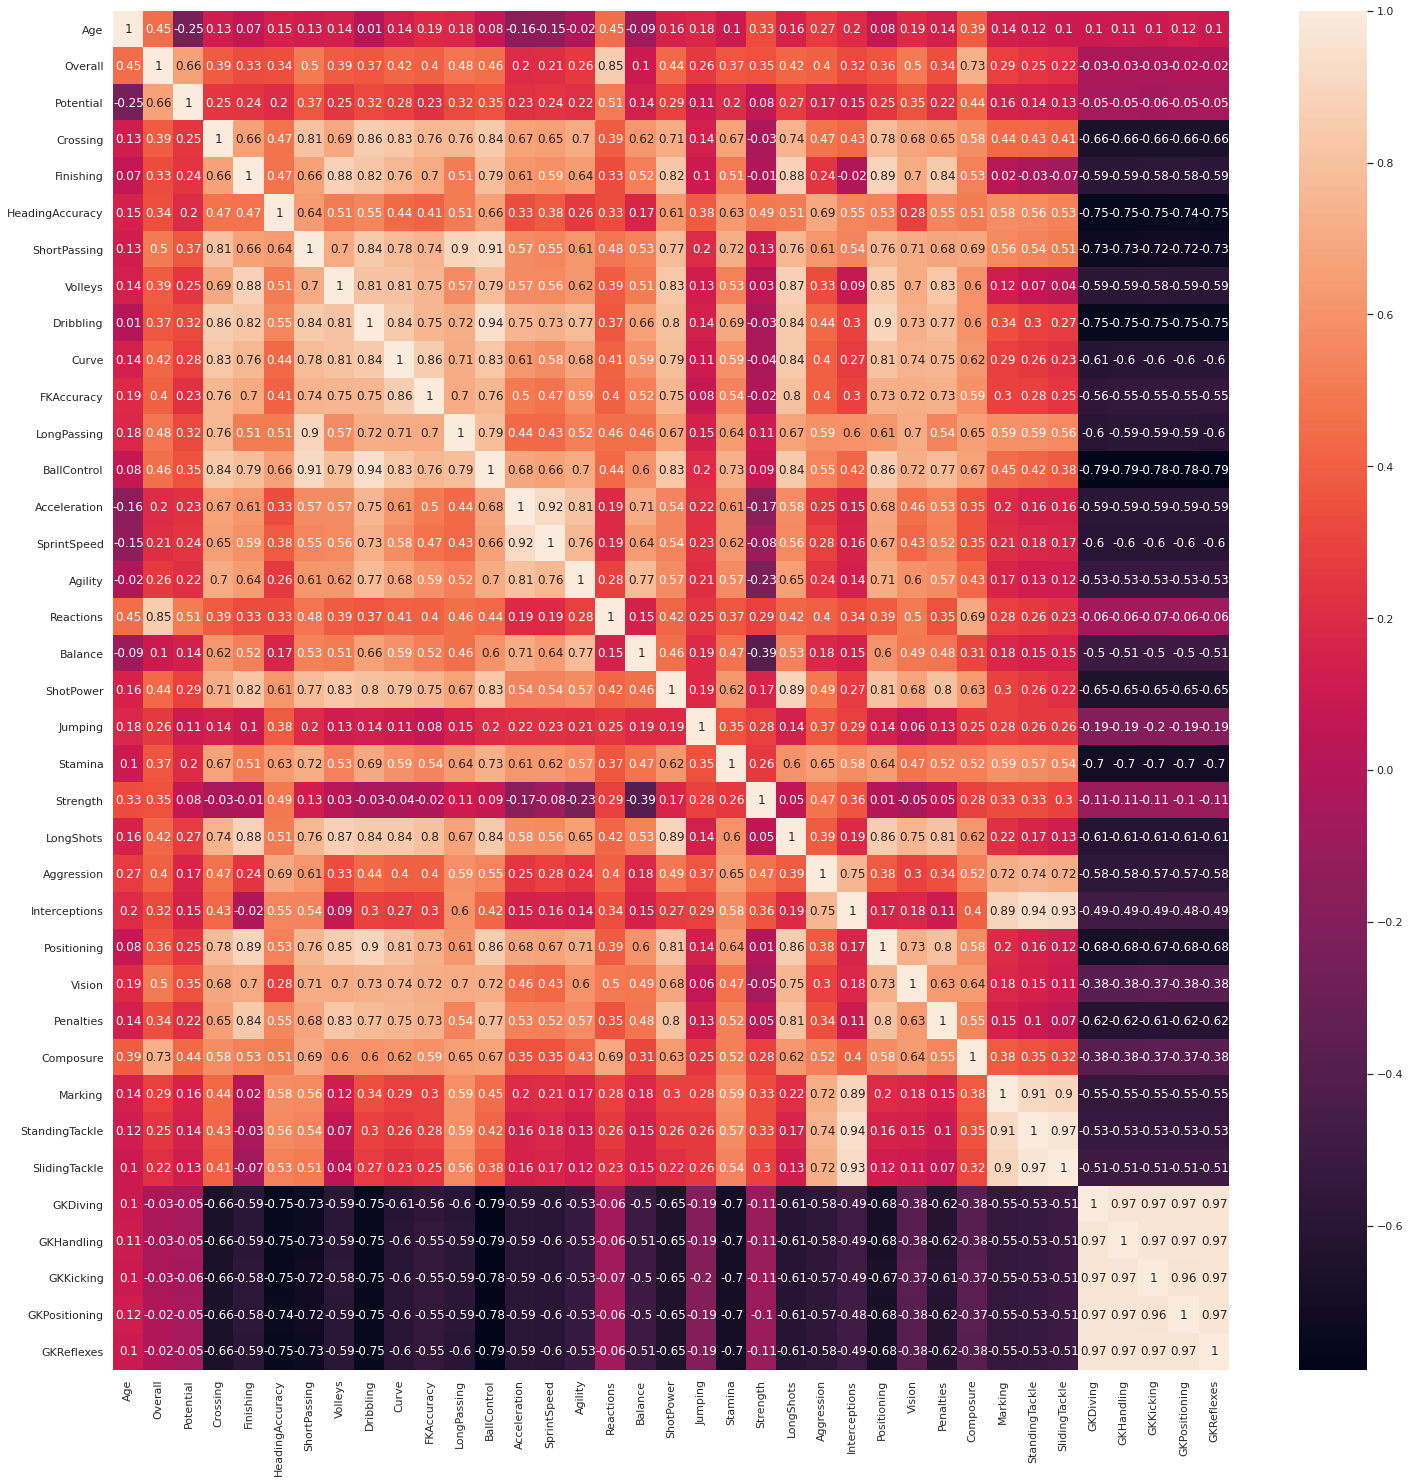

In [23]:
#Correlacao entre as variaveis númericas
plt.figure(figsize = (25,25))
sns.heatmap(fifa.corr().round(2), annot= True);

In [24]:
cons[cons.percentual == 0]['tipo'].value_counts()

float64    34
int64       3
Name: tipo, dtype: int64

In [26]:
# Eliminando os nulos do dataframe fifa
df = fifa.dropna()

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18159 entries, 0 to 18206
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              18159 non-null  int64  
 1   Overall          18159 non-null  int64  
 2   Potential        18159 non-null  int64  
 3   Crossing         18159 non-null  float64
 4   Finishing        18159 non-null  float64
 5   HeadingAccuracy  18159 non-null  float64
 6   ShortPassing     18159 non-null  float64
 7   Volleys          18159 non-null  float64
 8   Dribbling        18159 non-null  float64
 9   Curve            18159 non-null  float64
 10  FKAccuracy       18159 non-null  float64
 11  LongPassing      18159 non-null  float64
 12  BallControl      18159 non-null  float64
 13  Acceleration     18159 non-null  float64
 14  SprintSpeed      18159 non-null  float64
 15  Agility          18159 non-null  float64
 16  Reactions        18159 non-null  float64
 17  Balance     

In [29]:
df.head(2)

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,84.0,95.0,70.0,90.0,86.0,97.0,93.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,84.0,94.0,89.0,81.0,87.0,88.0,81.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0


In [28]:
# Redução da dimensionalidade utilizando PCA

pca = PCA(n_components=2)
projected = pca.fit_transform(df)
print(f"Original shape: {df.shape}, projected shape: {projected.shape}")

Original shape: (18159, 37), projected shape: (18159, 2)


In [30]:
# Variancia para a seleção de colunas do df

pca = PCA().fit(df)
evr = pca.explained_variance_ratio_
evr

array([5.65280555e-01, 1.81025219e-01, 5.95283391e-02, 4.34269284e-02,
       2.63532326e-02, 1.20707695e-02, 1.03550495e-02, 8.52951131e-03,
       7.87862979e-03, 7.20416677e-03, 7.18180297e-03, 6.32893542e-03,
       5.19242286e-03, 4.90798293e-03, 4.74209042e-03, 4.62772008e-03,
       4.25173246e-03, 3.86288432e-03, 3.76588448e-03, 3.75092615e-03,
       3.47815213e-03, 3.26730709e-03, 3.03137944e-03, 2.97415845e-03,
       2.56797543e-03, 2.30353342e-03, 2.14815132e-03, 1.56135904e-03,
       1.55351696e-03, 1.08664227e-03, 1.06824189e-03, 1.05891525e-03,
       9.58143746e-04, 8.89209394e-04, 8.59732430e-04, 7.34611045e-04,
       1.94187517e-04])

## Questão 1

Qual fração da variância consegue ser explicada pelo primeiro componente principal de `fifa`? Responda como um único float (entre 0 e 1) arredondado para três casas decimais.

In [6]:
def q1():
    pca = PCA().fit(df)
    evr = pca.explained_variance_ratio_
    return float(evr[0].round(3)) # Variancia do primeiro componente principal.

## Questão 2

Quantos componentes principais precisamos para explicar 95% da variância total? Responda como un único escalar inteiro.

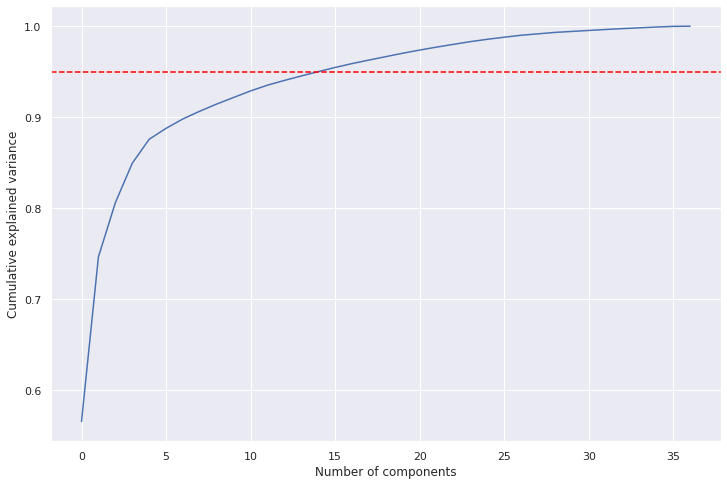

In [32]:
# Gráfico do numero de componentes para a variancia de 95% do total do df
g = sns.lineplot(np.arange(len(evr)), np.cumsum(evr))
g.axes.axhline(0.95, ls="--", color="red")
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

In [7]:
def q2():
    # Soma da variancia acumulada
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    component_number = np.argmax(cumulative_variance_ratio >= 0.95) + 1
    return int(component_number)

## Questão 3

Qual são as coordenadas (primeiro e segundo componentes principais) do ponto `x` abaixo? O vetor abaixo já está centralizado. Cuidado para __não__ centralizar o vetor novamente (por exemplo, invocando `PCA.transform()` nele). Responda como uma tupla de float arredondados para três casas decimais.

In [35]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

In [1]:
def q3():
    # PCA pata os 2 primeiros componentes
    pca = PCA(n_components=2).fit(df)
    # Mutiplicação de matriz, os 2 componentes pela matriz x
    return tuple(pca.components_.dot(x).round(3))
    

## Questão 4

Realiza RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma. Quais são as variáveis selecionadas? Responda como uma lista de nomes de variáveis.

In [46]:
def q4():
    # Regressão linear
    X = df.drop('Overall', axis=1)
    y = df.Overall
    
    reglin = LinearRegression().fit(X, y)
    # Classificação com eliminação recursiva de recursos
    selected = RFE(reglin, 5)
    selected = selected.fit(X, y)  
    # index da classificação
    index = selected.get_support(True)
    
    return list(X.columns[index])